<a href="https://colab.research.google.com/github/airoprojects/visiope/blob/main/test_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ai4MarsExperiments

#### Packages not included in colab

In [ ]:
%pip install torchmetrics
%pip install ipywidgets


## General imports

In [ ]:
# General imports

import os
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as metrics
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

## Custom Imports

In [ ]:
# Custom Imports
import sys

COLAB = 'google.colab' in sys.modules
LOCAL = not COLAB

if COLAB:

    # Clone visiope repo on runtime env
    !git clone https://github.com/airoprojects/visiope.git /content/visiope/
    %cd ./visiope/
    !git checkout main
    !git branch
    %cd ../

    # Get the root directory of the Git project
    root_dir = '/content/visiope'

    # Add custom modules to path
    custom_modules_path = root_dir + '/tools/'
    sys.path.insert(0, custom_modules_path)

elif LOCAL:

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    # Add custom modules to path
    custom_modules_path = root_dir  + '/tools/'
    sys.path.insert(0, custom_modules_path)


# Import Loader
from data.utils import Ai4MarsDownload, Ai4MarsImporter, Ai4MarsSplitter, Ai4MarsDataLoader

# Import Loss
from loss.loss import Ai4MarsCrossEntropy, Ai4MarsDiceLoss

# Import Trainer
from trainer.trainer import Ai4MarsTrainer

# Import Tester
from tester.tester import Ai4MarsTester

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cloning into '/content/visiope'...
remote: Enumerating objects: 1460, done.
remote: Counting objects: 100% (469/469), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 1460 (delta 228), reused 366 (delta 179), pack-reused 991
Receiving objects: 100% (1460/1460), 223.73 MiB | 12.89 MiB/s, done.
Resolving deltas: 100% (763/763), done.
/content/visiope
Already on 'main'
Your branch is up to date with 'origin/main'.
* main
/content


## Obtain dataset

#### Selecter functions

In [ ]:
# get the whole dataset
def get_d(b):

    global num_images
    global data_path
    global selector
    global X
    global y

    # Cannot select anymore
    if not selector:
        print("Cannot select multiple options")
        return
    selector = False

    # Insert here your local path to the dataset (temporary)
    data_path = input("Path to Dataset: ")

    # Insert here the number of images you want to download
    num_images = int(input("Number of images (max 1000): "))

    # Import data as Ai4MarsDataset
    Ai4MarsDownload()(PATH=data_path)
    importer = Ai4MarsImporter()
    X, y, _ = importer(PATH=data_path, NUM_IMAGES=num_images, SIZE=128)

    pass

# Enable loading chunk of data
def enable_chunk(b):

    global selector
    global CHUNK
    global current_chunk

    # Cannot select anymore
    if not selector:
        print("Cannot select multiple options")
        return
    selector = False

    CHUNK = True
    current_chunk = 0

    # Download options
    d300 = widgets.Button(description="Dataset 300")
    d500 = widgets.Button(description="Dataset 500")
    d1k = widgets.Button(description="Dataset 1000")

    # Actions
    display(d300, d500, d1k)
    d300.on_click(get_d300)
    d500.on_click(get_d500)
    d1k.on_click(get_d1k)

    pass

#### Data download funtions

In [ ]:
# ge the dataset in chncks of size 300
def get_d300(b):

    global COLAB
    global CHUNK
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    chunk_size = 300
    total_size = 3000

    # update current chunk
    current_chunk += chunk_size

    print(f"Loading cunck {current_chunk // chunk_size}")

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1WaQKmnty99798t6b-GMh15GVy9ZxCkGP?usp=drive_link'

            !gdown --folder {url} -O /content/

            load_data = '/content/small-chunk-dataset/'

    elif LOCAL:
        load_data = root_dir + '/datasetup/small-chunk-dataset/'

    X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

    print("Done")

    pass

# ge the dataset in chncks of size 500
def get_d500(b):

    global COLAB
    global CHUNK
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    chunk_size = 500
    total_size = 5000

    # update current chunk
    current_chunk += chunk_size

    print(f"Loading cunck {current_chunk // chunk_size}")

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1u4imSO8MerdZEW0V1lkEb6PWQmZgT5Ft?usp=sharing'

            !gdown --folder {url} -O /content/

            load_data = '/content/medium-chunk-dataset/'

    elif LOCAL:
        load_data = root_dir + '/datasetup/medium-chunk-dataset/'

    X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

    print("Done")
    pass

# ge the dataset in chncks of size 1k
def get_d1k(b):

    global COLAB
    global CHUNK
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    chunk_size = 1000
    total_size = 10000

    print(f"Loading cunck {current_chunk // chunk_size}")

    # update current chunk
    current_chunk += chunk_size

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1BhL0nLbQt930l_ISDgUS8ZJRWGjH4eUU?usp=sharing'

            !gdown --folder {url} -O /content/

            load_data = '/content/chunk-dataset/'

    elif LOCAL:
        load_data = root_dir + '/datasetup/chunk-dataset/'

    X, y = torch.load(load_data + 'dataset_' + str(current_chunk) + '.pt')

    pass

#### Selector

In [ ]:
# Select import mode

# ENV VARIABLE INITIALIZATION DO NOT CHANGE
CHUNK = False
current_chunk = 0
chunk_size = 0
total_size = 0
X = 0
y = 0

# Allow to select only one option
if 'selector' not in globals():
    selector  = True

# Selection buttons
d = widgets.Button(description="Load whole Dataset")
chunk = widgets.Button(description="Load chunk of data")


# actions
display(d, chunk)
d.on_click(get_d)
chunk.on_click(enable_chunk)


Button(description='Load whole Dataset', style=ButtonStyle())

Button(description='Load chunk of data', style=ButtonStyle())

Button(description='Dataset 300', style=ButtonStyle())

Button(description='Dataset 500', style=ButtonStyle())

Button(description='Dataset 1000', style=ButtonStyle())

Loading cunck 1
Retrieving folder list
Processing file 1AGzmQFqLZ2-mVFYlMRhds1Z_7xyPZVPk 1dataset.pt
Processing file 1gulZDZSPAn22HqvYVTVPnYB3ooQzkVpQ 2dataset.pt
Processing file 1AA1zXE8cSXBYbM3ZO6DM055E1b0FNRA9 3dataset.pt
Processing file 1o7p9Zba5ZEGrSk_Yny2cB0t6BnIG3OM- 4dataset.pt
Processing file 17awTePU083LXDbxqLU06Tmgnty_F7H03 5dataset.pt
Processing file 1-iUgD6-NAp0-XtSvmwBPX2qRbkYez7yw 6dataset.pt
Processing file 1Q4mgIjBdoGW455rg3XRJIY54Stztb68i 7dataset.pt
Processing file 1RG7iCTlQymx9pH8fLqChsqCQvfLllgVb 8dataset.pt
Processing file 1TTYTscK2UHIwtOTwQKLEobHSS6nkHe0N 9dataset.pt
Processing file 1wguJZXnmPtEXeNuAJYEp8kCIMb6sgBgq 10dataset.pt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1AGzmQFqLZ2-mVFYlMRhds1Z_7xyPZVPk
To: /content/small-chunk-dataset/1dataset.pt
100% 63.9M/63.9M [00:00<00:00, 79.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gulZDZSPAn22Hq

In [ ]:
# HARD RESET
# selector = True
# CHUNK = False

## DataLoader

In [ ]:
transform = None
# Uncomment the following lines to apply transformations to the dataset
'''
transform = transforms.RandomChoice([
    transforms.RandomRotation(90)])
'''

# Split the dataset
splitter = Ai4MarsSplitter()
percentages = [0.7, 0.2, 0.1]
train_set, test_set, val_set = splitter(X, y, percentages, transform=transform)

# Load info
load_info = './.info.pt'
info = torch.load(load_info)

# Build Ai4MarsDataloader
loader = Ai4MarsDataLoader()
batch_sizes = [32, 16, 16]
datasets = [train_set, test_set, val_set]
train_loader, test_loader, val_loader = loader(datasets, batch_sizes)

Splitting parameters: 
             Dataset: ai4mars-dataset-merged-0.1 
             Colab environment: True 
             Split percentages: [0.7, 0.2, 0.1] 
             Transformation: None 
             Svaving path: None 
             New image size: 128
Extrapolation of random inices ...
Splitting in progress ...
Done 

Building Dataloaders
Done 



Len of train set: 210
Len of test set: 60
Len of validation set: 30
image shape: torch.Size([128, 128, 3])


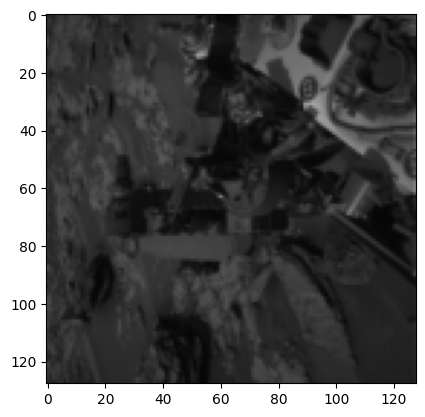

image shape: torch.Size([128, 128, 1])


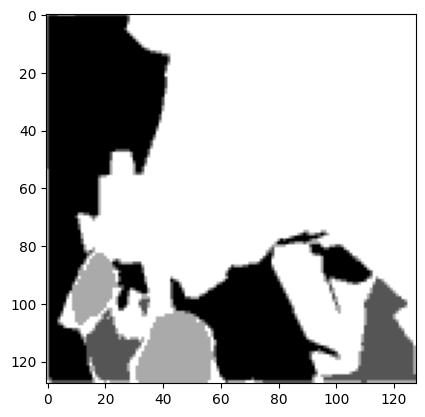

In [ ]:
# Just to check that different chunks contains different images
import matplotlib.pyplot as plt

print(f'Len of train set: {len(train_set)}')
print(f'Len of test set: {len(test_set)}')
print(f'Len of validation set: {len(val_set)}')

image, label = X[0], y[0]

print(f'image shape: {image.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(image.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'image shape: {label.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(label.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

# Free up mem
del X
del y

## Model setup

In [ ]:
# Clone remote repo with existing models

if COLAB:
    !git clone https://github.com/sithu31296/semantic-segmentation
    %pip install -e .
    %pip install -U gdown
    %cd semantic-segmentation

In [ ]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


In [ ]:
#  Import segformer

from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B2',
    num_classes=5
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth',
                                     map_location=device))
    print("Pretrained model's weights downloaded")
except:
    print("Download a pretrained model's weights from the result table.")

model.to(device)

print('Loaded Model')
%cd /content/

Download a pretrained model's weights from the result table.
Loaded Model
/content


## Training

#### Training parameters

In [ ]:
# Training parameters

loss_fn = Ai4MarsDiceLoss().to(device)
#loss_fn = Ai4MarsCrossEntropy().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

transform = None
# transform = transforms.RandomChoice([
#      transforms.RandomRotation(90)])

epochs = 5


trainer = Ai4MarsTrainer(loss_fn, optimizer, train_loader, val_loader,
                         transform=transform, device=device, info=info, model_name='segformer-MiT-B2', dump=True)

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/hist/


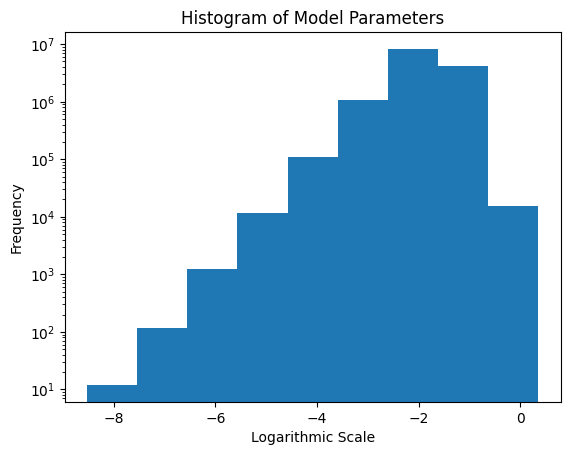

In [ ]:
# Model Parameters
# Check if the variable has been defined
if 'run_once' not in globals():
    run_once = True
    trainer.param_hist(model, label='before')

#### Regular training

In [ ]:
# Start training
trainer.train_multiple_epoch(model, EPOCHS=epochs)

#### Chunk training

In [ ]:

if not CHUNK:
    print("You are not allowd to perform chunk training proceede with regular traiing")

else:

    print("You are allowd to perform chunk training proceede with regular traiing")
    print("Please pay attention that you are using the same splitting parameters")

    CHUNK = False
    #stop_at = (total_size // chunk_size)
    stop_at = 3 # in this way load only 3 chunks

    for i in range(0, stop_at):

        if i == 0:
            print(f"Loading chunck {current_chunk // chunk_size}")
            trainer.train_multiple_epoch(model, EPOCHS=epochs)

        else:

            # update current chunk
            current_chunk += chunk_size

            print(f"Loading chunck {current_chunk // chunk_size}")

            if COLAB: load_data = '/content/small-chunk-dataset/'
            elif LOCAL: load_data = root_dir + '/datasetup/small-chunk-dataset/'

            X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

            # Build dataset
            splitter = Ai4MarsSplitter()
            train_set, test_set, val_set = splitter(X, y, percentages)

            # Build Ai4MarsDataloader
            loader = Ai4MarsDataLoader()
            train_loader, test_loader, val_loader = loader(
                [train_set, test_set, val_set], batch_sizes)

            trainer.train_multiple_epoch(model, EPOCHS=epochs)

You are allowd to perform chunk training proceede with regular traiing
Please pay attention that you are using the same splitting parameters
Loading chunck 7
EPOCH 1
Train loss: 0.5218401721545628
Time needed for training: 8.198822975158691 seconds
Validation loss: 0.7955003678798676 

EPOCH 2
Train loss: 0.4992397853306362
Time needed for training: 8.694865942001343 seconds
Validation loss: 0.8060550391674042 

EPOCH 3
Train loss: 0.4783975992883955
Time needed for training: 8.429712057113647 seconds
Validation loss: 0.8138003349304199 

EPOCH 4
Train loss: 0.4717432601111276
Time needed for training: 7.9299609661102295 seconds
Validation loss: 0.7989858984947205 

EPOCH 5
Train loss: 0.486517139843532
Time needed for training: 8.452381610870361 seconds
Validation loss: 0.5920807123184204 

Loading chunck 8
Splitting parameters: 
             Dataset: ai4mars-dataset-merged-0.1 
             Colab environment: True 
             Split percentages: [0.7, 0.2, 0.1] 
             Transfo

In [ ]:
#HARD RESET
CHUNK = True
current_chunk = 2100

#### Plot loss

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/loss/


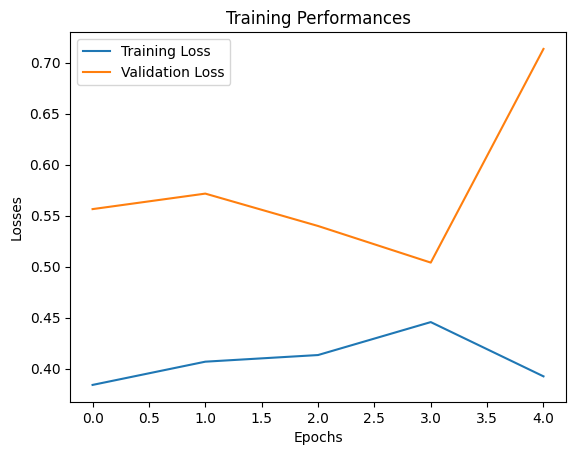

Train mean loss: 0.4084639021328518
Validation mean loss: 0.5770066142082214


In [ ]:
# Plot loss

import matplotlib.pyplot as plt

trainer.plot_loss()

## Testing

In [ ]:
# Testing and evaluation Metrics

metric = metrics.JaccardIndex(task="multiclass", num_classes=5).to(device)
tester = Ai4MarsTester(loss_fn, metric, test_loader, device=device)

In [ ]:
# Start testing

tester.test_one_epoch(model)

Test loss: 0.7462586909532547

Metrics MulticlassJaccardIndex(): 0.4056648313999176


Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/hist/


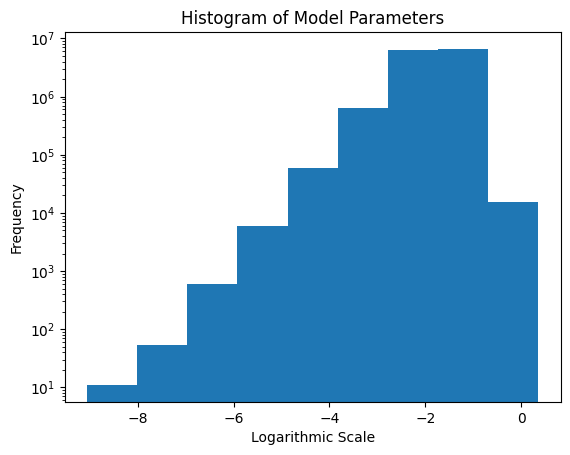

In [ ]:
# Module Parameters
trainer.param_hist(model, label='after')

torch.Size([16, 3, 128, 128])


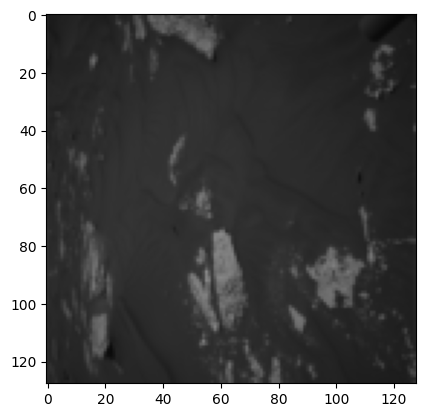

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


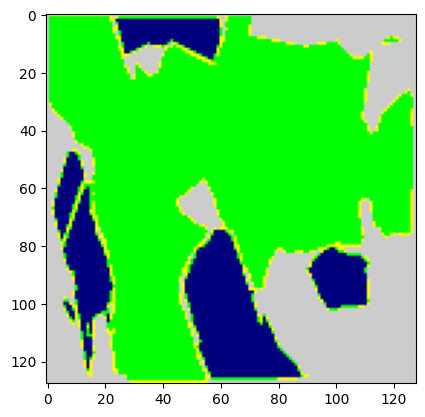

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


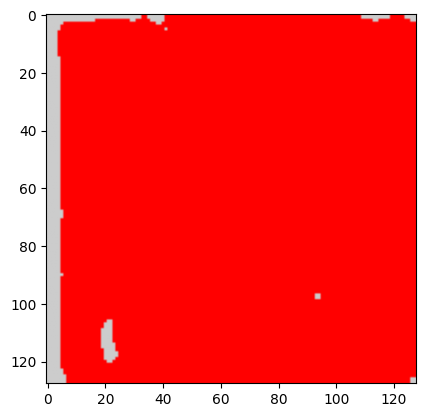

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/
torch.Size([16, 3, 128, 128])


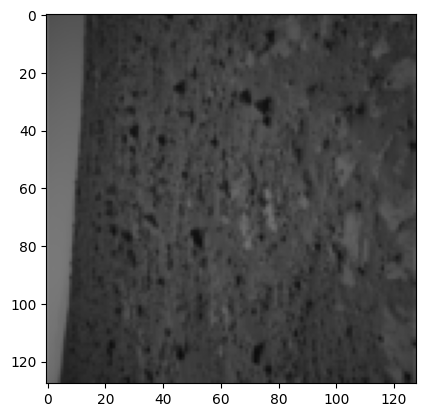

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


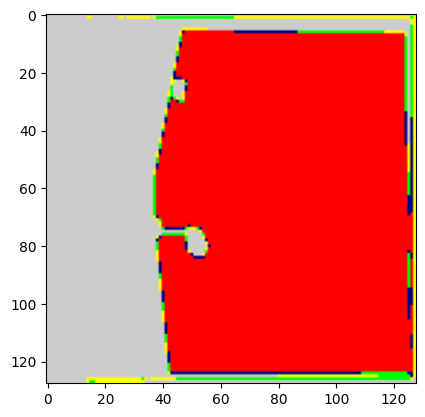

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


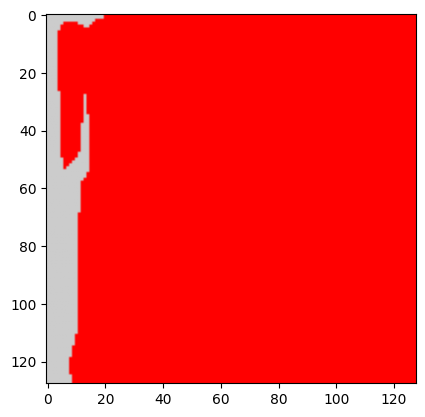

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/
torch.Size([16, 3, 128, 128])


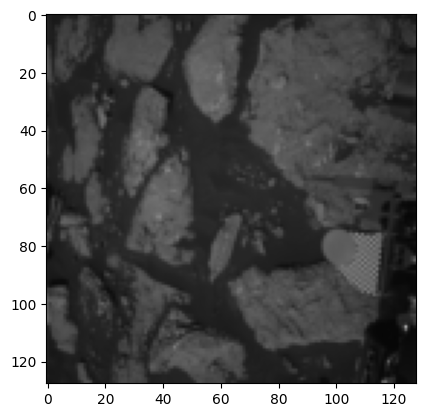

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


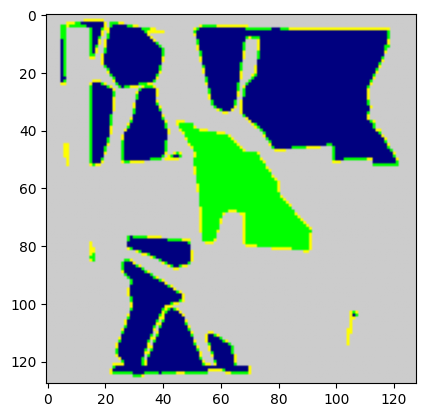

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


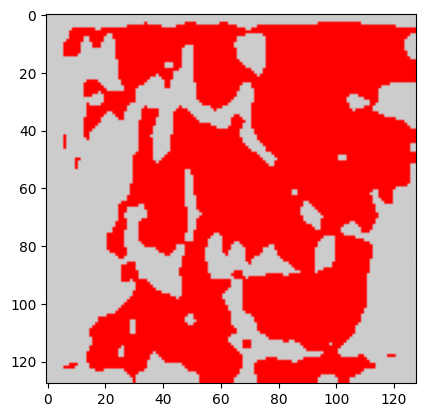

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/
torch.Size([12, 3, 128, 128])


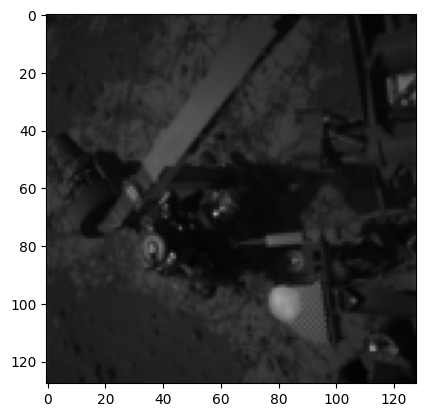

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


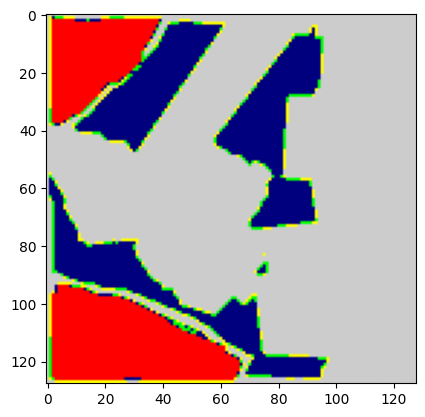

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


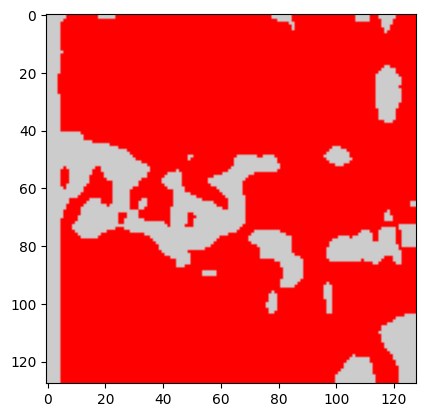

Data will be saved in ./dump/20230718-173725-segformer-MiT-B2/images/


In [ ]:
model.eval()

for i, batch in enumerate(test_loader):
  image, label = batch
  print(image.shape)
  pred = model(image.to(device))
  tester.show_images(image, trainer.results_path, index=i)
  tester.show_seg(label, trainer.results_path, index=i)
  tester.show_seg(pred.cpu(), trainer.results_path, index=i)

In [ ]:
# To save file once you trained
!zip -r 20230718-173725-segformer-MiT-B2.zip /content/dump/20230718-173725-segformer-MiT-B2
from google.colab import files

#files to save
files.download("20230718-173725-segformer-MiT-B2.zip")

  adding: content/dump/20230718-173725-segformer-MiT-B2/ (stored 0%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/hist/ (stored 0%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/hist/parameters_hist_before_20230718_173738.png (deflated 20%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/hist/parameters_hist_after_20230718_180128.png (deflated 19%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/model_state/ (stored 0%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/model_state/config (deflated 22%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/loss/ (stored 0%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/loss/loss_plot_20230718_180029.png (deflated 10%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/loss/loss_plot_20230718_174920.png (deflated 10%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/loss/loss_plot_20230718_174609.png (deflated 9%)
  adding: content/dump/20230718-173725-segformer-MiT-B2/Un

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>